# Simple power spectrum estimation from an input dataset
This example shows how to estimate the power spectrum from a set of data files using an Optimal Quadratic Estimator (OQE) approach.

In [1]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import itertools
from funcsigs import signature
from hera_pspec.data import DATA_PATH

## Loading the input data: forming power spectra from adjacent time integrations

The input data are specified as a list of `UVData` objects, which are then packaged into a `PSpecData` class. This class is responsible for collecting the data and covariances together and performing the OQE power spectrum estimation.

At least two `UVData` objects must be specified, these could be different datasets, or just copies of a single dataset, given the use-case. In what follows, we will use only one data set and produce two copies of it, but will shift the second dataset by one time integration and interleave it relative to the first, such that we can form auto-baseline power spectra without noise-bias. 

In [2]:
# select the data file to load
dfile = os.path.join(DATA_PATH, 'zen.all.xx.LST.1.06964.uvA')

# Load into UVData objects
uvd = UVData()
uvd.read_miriad(dfile)

# Check which baselines are available
print(uvd.get_antpairs())

[(24, 24), (24, 25), (24, 37), (24, 38), (24, 39), (25, 25), (25, 37), (25, 38), (25, 39), (37, 37), (37, 38), (37, 39), (38, 38), (38, 39), (39, 39)]


## Define a cosmology

Here we will instantiate a `hera_pspec.conversions.Cosmo_Conversions` object that will define the cosmology we adopt throughout this notebook. **All calculations that depend on a cosmology will be tied to the one we adopt here: the various objects in `hera_pspec` will pass this specific object between themselves, which starts by attaching the cosmology to a `PSpecBeamUV` object.** Further on in the notebook, we will see how we can explicitly overwrite the adopted cosmology and appropriately re-calculate the necessary variables.

In [3]:
# Instantiate a Cosmo Conversions object
# we will need this cosmology to put the power spectra into cosmological units
cosmo = hp.conversions.Cosmo_Conversions()
print cosmo

Cosmo_Conversions object at <0x11bacbf50>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700


Instantiate a beam object, and attach the cosmo conversions object onto it.

In [4]:
# List of beamfile to load. This is a healpix map.
beamfile = os.path.join(DATA_PATH, 'NF_HERA_Beams.beamfits')

# intantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

Next convert from Jy units to mK. This involves calculating the effective beam area (see HERA Memo #27 and #43), which can be done with the beam object we instantiated earlier.

In [5]:
# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array))

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

Configure data and instantiate a `PSpecData` object, while also feeding in the beam object.

In [6]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

## Phase second `dset` to first `dset`

Because we are forming power spectra between datasets that are offset in LST there will be some level of decoherence (and therefore signal loss) of the EoR signal. For short baselines and small LST offsets this is typically negligible, but it is still good to try to recover what coherency we can, simply by phasing (i.e. fringe-stopping) the datasets before forming the power spectra. This can be done with the `rephase_to_dset` method, and can only be done once. 

In [7]:
# Because the LST integrations are offset by more than ~15 seconds we will get a warning
# but this is okay b/c it is still **significantly** less than the beam-crossing time and we are using short
# baselines...

# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)

In [8]:
# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

## Estimating the power spectrum for a handful of baseline pairs (auto-baseline pspec)
Estimate the power spectrum for a handful baseline pairs between the two datasets in `ds.dsets`. You can specify which baselines are included in the power spectrum estimate, which datasets to use, what freq channels to use, and how the estimate should be weighted.

In [9]:
# Specify which baselines to include
baselines = [(24,25), (37,38), (38,39)]

### Read the docstring! Here are the first few lines...

In [10]:
print "ds.pspec{}".format(signature(ds.pspec))
print '\n'.join(ds.pspec.__doc__.split('\n')[:30])

ds.pspec(bls1, bls2, dsets, pols, input_data_weight='identity', norm='I', taper='none', little_h=True, spw_ranges=None, verbose=True, history='')

        Estimate the delay power spectrum from a pair of datasets contained in 
        this object, using the optimal quadratic estimator of arXiv:1502.06016.

        In this formulation, the power spectrum is proportional to the 
        visibility data via
        
        P = M data_{LH} E data_{RH}

        where E contains the data weighting and FT matrices, M is a 
        normalization matrix, and the two separate datasets are denoted as 
        "left-hand" and "right-hand".

        Each power spectrum is generated by taking a baseline (specified by 
        an antenna-pair and polarization key) from bls1 out of dsets[0] and 
        assigning it as data_LH, and a bl from bls2 out of the dsets[1] and 
        assigning it as data_RH.

        If the bl chosen from bls1 is (ant1, ant2) and the bl chosen from bls2 
        is (ant3,

Call the `PSpecData.pspec` function to use the OQE framework. The result is a `UVPSpec` object that holds all of the power spectra and their meta-data.

In [11]:
# we will use the baselines list to produce 3 power spectra
# whose data will be drawn from the dsets[0] and dsets[1]
# across two spectral windows with identity weighting and a blackman-harris taper
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400), (600,721)], input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (300, 400)

Using polarization pair: ('XX', 'XX')

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: (-5, -5)
  Setting weight matrix for input data...
  Building G...
(0, 24, 25, 'XX') --- (1, 24, 25, 'XX')
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))
pol: (-5, -5)
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 39), (38, 39))
pol: (-5, -5)
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (600, 721)

Using polarization pair: ('XX', 'XX')

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: (-5, -5)
  Setting weight matrix for input data...
  Building G...
(0, 24, 25, 'XX') --- (1, 24, 25, 'XX')
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar..

## Making sense of the meta-data

The fundamental unit in the `UVPSpec` object is a single delay spectrum, indexed by a spectral window selection (`spw`), a baseline-pair selection (`blpair`) and a polarization (`pol`). Spectral windows are marked by their index (see `spw_array`), polarization are marked by their pol string (`xx`) or pol integer (`-5`), and a baseline-pair is marked by its blpair integer, which is simply the antenna numbers put into length-3 integers and concatenated. For example, the baseline-pair `((100, 200), (300, 400))` would have a blpair integer `100200300400`.

To access particular slices of the data in a `UVPSpec` object, the user should interface with the `get_data` method, which takes a selection of `spw`, `blpair` and `pol` as arguments. See the example below.

In [12]:
# let's get the delay spectra from spw 0, blpair ((24, 25), (24, 25)) and xx pol
key = (0, ((24, 25), (24, 25)), 'xx')

# output should be shape (Ntimes, Ndlys)
print uvp.get_data(key).shape

# we can also access data by feeding a dictionary
key = {'pol':'xx', 'spw': 0, 'blpair':((24, 25), (24, 25))}
print uvp.get_data(key).shape

(3, 100)
(3, 100)


There is also metadata telling you things like the data weighting, normalization, tapering, units, telescope location, LST and JD time stamps, etc.

In [13]:
# get power spectrum units
print "pspec units: ", uvp.units

# get weighting
print "pspec weighting: ", uvp.weighting

pspec units:  (mK)^2 h^-3 Mpc^3
pspec weighting:  identity


Also, importantly, the cosmology we adopted originally and passed through to the beam and `PSpecData` objects was passed through to this `UVPSpec` object.

In [14]:
print uvp.cosmo

Cosmo_Conversions object at <0x11bacbf50>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700


## Plotting

Here is an example of how to do some simple and quick plotting of power spectra, which includes getting the power spectra and the delay bins of their bandpowers.

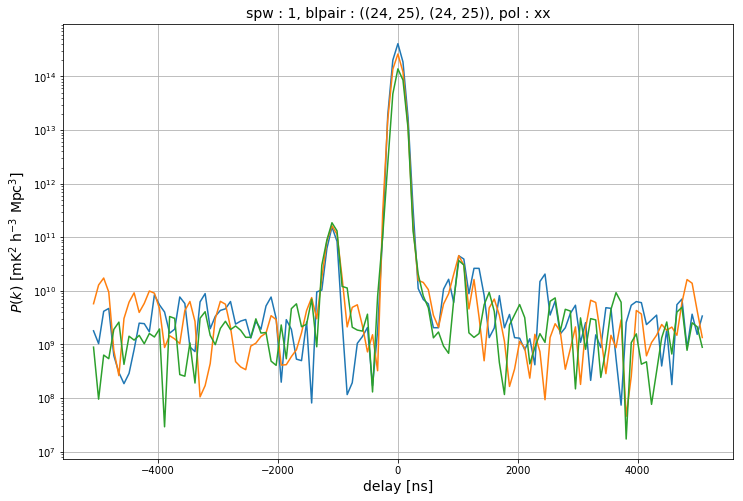

In [15]:
# plot power spectrum of spectral window 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp =((24, 25), (24,25))
key = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

p1 = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

## Form redundant baseline spectra (auto & cross baseline pspec)

Above we looked at auto-baseline power spectra. Here we will show how to form power spectra between groups of redundant baselines. To do this, we use the `pspecdata.construct_blpairs` helper function to construct the `baselines1` and `baselines2` lists that we then feed into `PSpecData.pspec`. This takes keywords `exclude_auto_bls`, which will remove all baselines paired with itself from the final `blpairs` list, as well as `exclude_permutations`, which will use a combination instead of a permutation to form the baseline-pairs from the input `baselines` list.

In [16]:
# baselines is a redundant baseline group
baselines = [(24,25), (37,38), (38,39)]

# calculate all baseline pairs from group
baselines1, baselines2, blpairs = hp.pspecdata.construct_blpairs(baselines, exclude_auto_bls=True, 
                                                                 exclude_permutations=True)

# Inspect baseline pairs
print blpairs

[((24, 25), (37, 38)), ((24, 25), (38, 39)), ((37, 38), (38, 39))]


Now we feed these lists through to `pspec`

In [17]:
uvp = ds.pspec(baselines1, baselines2, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400), (600,721)], input_data_weight='identity', 
               norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (300, 400)

Using polarization pair: ('XX', 'XX')

(bl1, bl2) pair: ((24, 25), (37, 38))
pol: (-5, -5)
  Setting weight matrix for input data...
  Building G...
(0, 24, 25, 'XX') --- (1, 37, 38, 'XX')
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 25), (38, 39))
pol: (-5, -5)
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (38, 39))
pol: (-5, -5)
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (600, 721)

Using polarization pair: ('XX', 'XX')

(bl1, bl2) pair: ((24, 25), (37, 38))
pol: (-5, -5)
  Setting weight matrix for input data...
  Building G...
(0, 24, 25, 'XX') --- (1, 37, 38, 'XX')
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar..

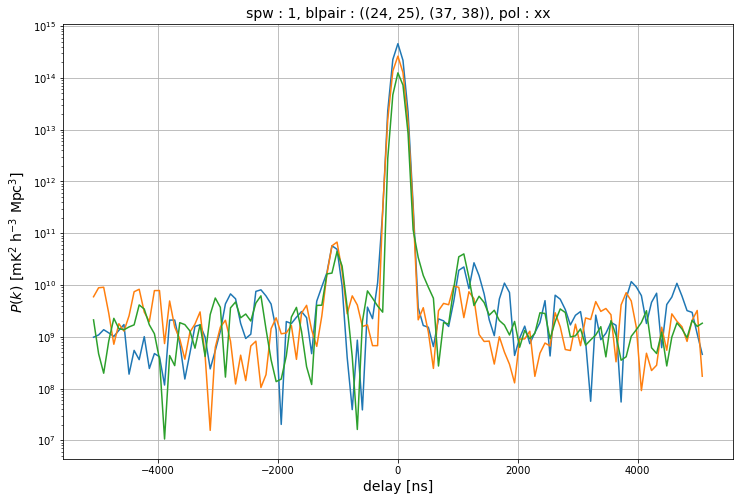

In [18]:
# plot power spectrum of a cross-baseline pspectra from spectral window 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp =((24, 25), (37, 38))
key = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

_ = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

## Convert to $\Delta^2(k)$

You can convert the power spectrum data from $P(k)$ format to "unitless" power spectrum $\Delta^2(k)$ by scaling by the cosmological wave-vectors cubed. This can be done by hand with the `get_kparas()` and `get_kperps()` methods, or can be done automatically using the `convert_to_deltasq()` method.

The cosmology used for this calculation will be the one stored in the `UVPSpec` object, which, recall, is the same cosmology we adopted originally.

In [19]:
# make a copy of the UVPSpec object
dsq = copy.deepcopy(uvp)

# how to get the wave vectors for spw = 1 by hand
k_perp, k_para = dsq.get_kperps(1, little_h=True), dsq.get_kparas(1, little_h=True)

# convert to deltasq automatically
dsq.convert_to_deltasq()

# see that units have automatically changed
print "dsq units: ",dsq.units

dsq units:  (mK)^2 k^3 / (2pi^2)


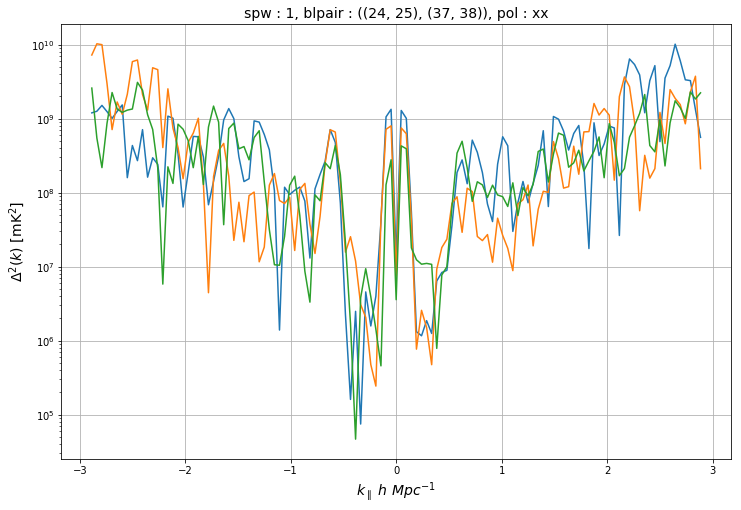

In [20]:
# plot deltasq power spectrum of spw 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp =((24, 25), (37, 38))
key = (spw, blp, 'xx')
power = np.abs(np.real(dsq.get_data(key)))

_ = ax.plot(k_para, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k_{\parallel}\ h\ Mpc^{-1}$", fontsize=14)
ax.set_ylabel(r"$\Delta^2(k)\ \rm [mK^2]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

## Plotting Thermal Noise Curves

Using the `hera_pspec.noise` module, you can plot analytic thermal noise power spectra given a $T_{\rm sys}$ and a `UVPSpec` object, which carries with it the integration time and number of incoherent averages for **each delay spectrum** it contains.

To do this, all you need to do as the user is to interface with the `UVPSpec.generate_noise_spectra()` method. Given a selection of spectral window, polarization, system temperature and optionally which blpairs to compute for, it will return a dictionary of thermal noise curves (in either $P(k)$ or $\Delta^2(k)$ depending on `form` kwarg) for each baseline-pair in the `UVPSpec` object.

In [21]:
# generate noise curves for spw 0, pol 'xx' with a Tsys of 300 K
spw = 1
pol = 'xx'
Tsys = 300
P_N = uvp.generate_noise_spectra(spw, pol, Tsys)

Have generated the `Sense` object, we can now call `generate_noise_spectra` to produce noise curves. The result is a dictionary with baseline-pair integers as keys and ndarrays as values.

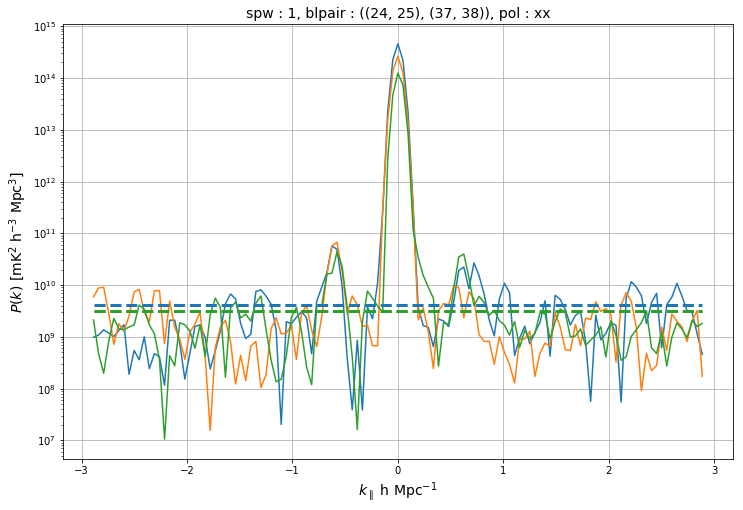

In [22]:
# plot power spectrum of spw 1 with noise curves
fig, ax = plt.subplots(figsize=(12,8))

blp = ((24, 25), (37, 38))
key = (spw, blp, pol)
power = np.abs(np.real(uvp.get_data(key)))

_ = ax.plot(k_para, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k_\parallel\ \rm h\ Mpc^{-1}$", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

# plot noise curves for this baseline-pair
ax.set_prop_cycle(None)
_ = ax.plot(k_para, P_N[uvp.antnums_to_blpair(blp)].T, ls='--', lw=3)

## Incoherent Averaging

The `UVPSpec` object supports incoherent averaging across baseline-pairs and/or time using the `UVPSpec.average_spectra()` method. If the baseline-pairs are grouped by redundancy, this is equivalent to binning onto a single 3D $k_x, k_y, k_\parallel$ space. If the baseline-pairs are grouped by baseline separation, this is equivalent to cylindrical binning in $k_\perp$ and $k_\parallel$. Spherical binning to form a true 1D power spectrum is currently not supported.

Below we will incoherently average across all baseline-pairs in the `UVPSpec` object, knowing that we only constructed 14.6 m power spectra, so we are reasonably justified in doing so.

In [23]:
# form the baseline-pair group, which will be a single group 
# consisting of all baseline-pairs in the object
blp_group = [sorted(np.unique(uvp.blpair_array))]

# average spectra with inplace = False and assign to a new "uvp2" object
uvp2 = uvp.average_spectra(blpair_groups=blp_group, time_avg=True, inplace=False)

We can then plot the averaged power spectrum, along with a new noise curve which will know to account for the averaging based on the changes to the `integration_array` and `nsample_array`. The colored lines show the same un-averaged pspectra from before, while the black line shows the averaged power spectrum, along with its new thermal noise estimate.

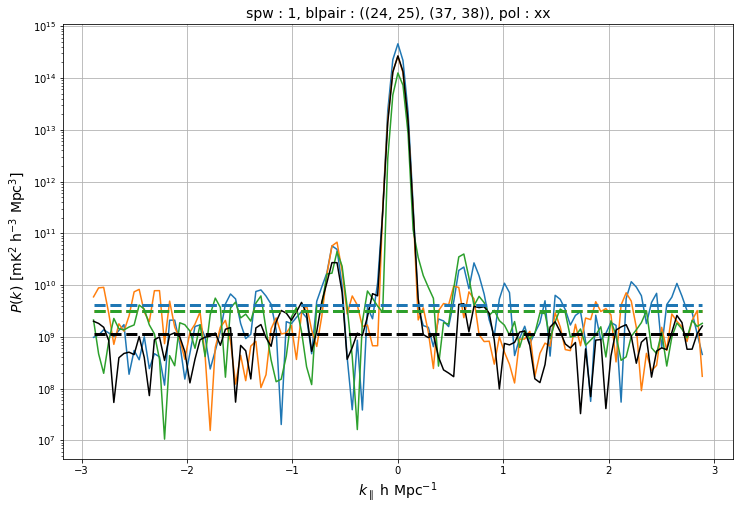

In [24]:
# plot power spectrum of spw 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp = ((24, 25), (37, 38))
pol = 'xx'
key = (spw, blp, pol)
k_para = uvp.get_kparas(spw)
power = np.abs(np.real(uvp.get_data(key)))
P_N = uvp.generate_noise_spectra(spw, pol, 300)
P_N = P_N[uvp.antnums_to_blpair(blp)]

avg_power = np.abs(np.real(uvp2.get_data(key)))
avg_P_N = uvp2.generate_noise_spectra(spw, pol, 300)
avg_P_N = avg_P_N[uvp2.antnums_to_blpair(blp)]

_ = ax.plot(k_para, power.T)
ax.plot(k_para, avg_power.T, color='k')
ax.plot(k_para, avg_P_N.T, color='k', ls='--', lw=3)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k_\parallel\ \rm h\ Mpc^{-1}$", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

ax.set_prop_cycle(None)
_ = ax.plot(k_para, P_N.T, ls='--', lw=3)

## Fold the power spectra

The power spectra are natively across positive and negative delays, but often we make plots with only positive delay bins. In addition, averaging bandpowers with identical negative with positive bandpowers gives us an extra factor of sqrt 2 sensitivity, which we can do with the `fold_spectra()` method.

In [25]:
uvp.fold_spectra()

In [26]:
uvp2.fold_spectra()

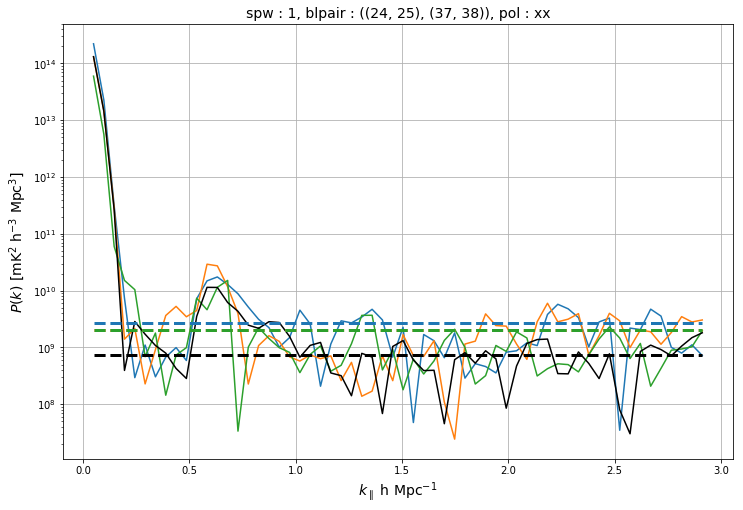

In [27]:
# plot power spectrum of spw 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp =((24, 25), (37, 38))
pol = 'xx'
key = (spw, blp, pol)
k_para = uvp.get_kparas(spw)
power = np.abs(np.real(uvp.get_data(key)))
P_N = uvp.generate_noise_spectra(spw, pol, 300)
P_N = P_N[uvp.antnums_to_blpair(blp)]

avg_power = np.abs(np.real(uvp2.get_data(key)))
avg_P_N = uvp2.generate_noise_spectra(spw, pol, 300)
avg_P_N = avg_P_N[uvp2.antnums_to_blpair(blp)]

_ = ax.plot(k_para, power.T)
ax.plot(k_para, avg_power.T, color='k')
ax.plot(k_para, avg_P_N.T, color='k', ls='--', lw=3)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k_\parallel\ \rm h\ Mpc^{-1}$", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

ax.set_prop_cycle(None)
_ = ax.plot(k_para, P_N.T, ls='--', lw=3)

## Re-defining the cosmology

We started by adopting a single cosmology, which was automatically passed between the various `hera_pspec` objects without user intervention in order to preserve self-consistency. If, however, we would like to adopt a *new cosmology*, we need to re-compute certain cosmology-dependent quantities, namely the normalization of the power spectrum scalar (see HERA Memos #27 and #43). We can do this with the `UVPSpec.set_cosmology` object.

In [28]:
# define a new cosmology with no dark energy
new_cosmo = hp.conversions.Cosmo_Conversions(Om_L = 0.0)

# attempt to overwrite the current UVPSpec cosmology:
# this will fail b/c one already exists and overwrite=False
uvp.set_cosmology(new_cosmo)

self.cosmo exists and overwrite == False, not overwriting...


In [29]:
# now set overwrite = True
uvp.set_cosmology(new_cosmo, overwrite=True)

setting cosmology: 
Cosmo_Conversions object at <0x11e6ff690>
Om_L : 0.0000; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.6865; H0 : 67.2700
Updating scalar array and re-normalizing power spectra


## Perform data selection on `UVPSpec`

We can select out parts of the data using the `select` function.

In [30]:
# select all baseline-pairs containing the baseline (24, 25)
# only_pairs_in_bls means to select only blpairs that have baseline1 _and_ baseline2 in the bls list
uvp2 = uvp.select(bls=[(24, 25)], inplace=False, only_pairs_in_bls=False)

# check than only baseline-pairs with a (24, 25) in them are kept
print "baseline pairs in uvp2: \n", map(lambda blp: uvp2.blpair_to_antnums(blp), np.unique(uvp2.blpair_array))

baseline pairs in uvp2: 
[((24, 25), (37, 38)), ((24, 25), (38, 39))]


## Write to HDF5

Write to disk using the `write_hdf5` method. Easy as that.

In [31]:
uvp.write_hdf5("pspec.hdf5", overwrite=True)

## Read from HDF5

Read the whole file, just the meta-data, or a data selection for partial I/O.

Frist, let's **read the whole file** and look at some meta-data.

In [32]:
# read the whole file
uvp2 = hp.uvpspec.UVPSpec()
uvp2.read_hdf5("pspec.hdf5")

In [33]:
# print some meta-data
print "pols : ", uvp2.pol_array
print "number of baseline-pairs: ",uvp2.Nblpairs

pols :  [-5]
number of baseline-pairs:  3


In [34]:
# Ensure data_array exists b/c we read the whole file
print "data_array in uvp2 : ", hasattr(uvp2, 'data_array')

data_array in uvp2 :  True


Now read **only the meta-data**.

In [35]:
# read only the meta-data
uvp2.read_hdf5("pspec.hdf5", just_meta=True)

In [36]:
# print some meta-data
print "pols : ", uvp2.pol_array
print "number of baseline-pairs: ",uvp2.Nblpairs

pols :  [-5]
number of baseline-pairs:  3


In [37]:
# Ensure data_array doesn't exist b/c we only loaded the meta-data
print "data_array in uvp2 : ", hasattr(uvp2, 'data_array')

data_array in uvp2 :  False


Now do **partial loading of certain baseline pairs**.

In [38]:
# partial load on certain baseline-pairs 
uvp2.read_hdf5("pspec.hdf5", just_meta=False, bls=[(37, 38), (38, 39)], only_pairs_in_bls=True)

# print baseline pairs
print "baseline pairs in uvp2: \n", map(lambda blp: uvp2.blpair_to_antnums(blp), np.unique(uvp2.blpair_array))

baseline pairs in uvp2: 
[((37, 38), (38, 39))]


Now do **partial loading of certain times**. To do this, we need to feed the exact float of the times we want, but how do we get these to float precision in the first place without loading the whole file? This is where the `just_meta` load comes in handy.

First load just the metadata, then do a partial load using the times you desire from the metadata.

In [39]:
# read only meta
uvp2.read_hdf5("pspec.hdf5", just_meta=True)

# now only load in one of the time integrations
uvp2.read_hdf5("pspec.hdf5", times=np.unique(uvp2.time_avg_array)[:1])

# check that only one time integration exists, but that all baseline pairs exist
print "number of unique times: ", len(np.unique(uvp2.time_avg_array))
print "number of baseline-pairs: ",uvp2.Nblpairs

number of unique times:  3
number of baseline-pairs:  3


In [40]:
if os.path.exists("pspec.hdf5"): os.remove("pspec.hdf5")

## Forming Pseudo-Stokes Power Spectra

Forming polarized pseudo-Stokes power spectra is identical to forming linear-dipole polarization power spectra, except that we need pseudo-Stokes visibilities and beam models. See the `Forming_PseudoStokes_Vis` notebook on details on how to do that. Here we will show how to form pseudo-I spectra. 

In [41]:
# form pseudoI visibility
dset1 = os.path.join(DATA_PATH, 'zen.all.xx.LST.1.06964.uvA')  # xx miriad file
dset2 = os.path.join(DATA_PATH, 'zen.all.yy.LST.1.06964.uvA')  # yy miriad file
uvdI = hp.pstokes.construct_pstokes(dset1=dset1, dset2=dset2, pstokes='pI')

In [42]:
# List of beamfile to load. This is a healpix map for both XX and YY, and can therefore make an I map
beamfile = os.path.join(DATA_PATH, 'NF_HERA_Beams.beamfits')

# intantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

In [43]:
# find conversion factor from Jy to mK for pseudo-stokes I pol
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvdI.freq_array), pol='pI')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvdI.data_array *= Jy_to_mK[None, None, :, None]

# changeunits of UVData objects
uvdI.vis_units = 'mK'

In [44]:
# instantiate a PSpecData object
ds = hp.PSpecData(dsets=[uvdI, uvdI], wgts=[None, None], beam=uvb)

In [45]:
# baselines is a redundant baseline group
baselines = [(24,25), (37,38), (38,39)]

# calculate all baseline pairs from group
baselines1, baselines2, blpairs = hp.pspecdata.construct_blpairs(baselines, exclude_auto_bls=True, 
                                                                 exclude_permutations=True)

# Inspect baseline pairs
print blpairs

[((24, 25), (37, 38)), ((24, 25), (38, 39)), ((37, 38), (38, 39))]


In [46]:
uvp = ds.pspec(baselines1, baselines2, (0, 1), [('pI', 'pI')], spw_ranges=[(300, 400)], 
               input_data_weight='identity', norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (300, 400)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((24, 25), (37, 38))
pol: (1, 1)
  Setting weight matrix for input data...
  Building G...
(0, 24, 25, 'pI') --- (1, 37, 38, 'pI')
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 25), (38, 39))
pol: (1, 1)
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (38, 39))
pol: (1, 1)
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


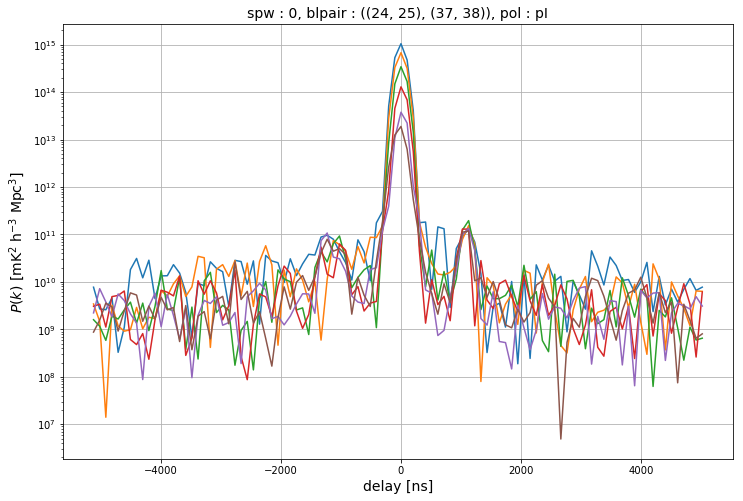

In [47]:
# plot power spectrum of spectral window 0
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
blp = ((24, 25), (37, 38))
key = (spw, blp, 'pI')
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

p1 = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

## Using Custom Polarized Beams

In the case that you have information on polarized beams that can't be put into a `UVBeam` object, you can use the custom beam capability of `hera_pspec.pspecbeam.PSpecBeamFromArray`, which will allow you to create a `PSpecBeam` object from custom $\Omega_P$ and $\Omega_{PP}$ arrays. See the `PSpecBeam` tutorial to see how to do this. 

One can then use this object in the same way as above to create polarized power spectra with custom polarized beams.